In [41]:
#Importing the required libraries

In [90]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import shutil
import pywt
import joblib
import json
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

#### Reading the image in BGR format and also converting it into grayscale

In [34]:
img=cv2.imread(r"D:\Classification_project\model\test_images\sh.jpg")

In [35]:
print(img) #In computer1s images are represented in the form of arrays
print(img.shape)           #This is a bgr or rgb image which is 3D

[[[175 180 178]
  [175 180 178]
  [175 180 178]
  ...
  [206 209 207]
  [206 209 207]
  [206 209 207]]

 [[176 181 179]
  [176 181 179]
  [176 181 179]
  ...
  [206 209 207]
  [206 209 207]
  [206 209 207]]

 [[176 181 179]
  [176 181 179]
  [176 181 179]
  ...
  [207 210 208]
  [207 210 208]
  [207 210 208]]

 ...

 [[189 194 193]
  [189 194 193]
  [189 194 193]
  ...
  [199 202 200]
  [199 202 200]
  [199 202 200]]

 [[188 193 192]
  [188 193 192]
  [188 193 192]
  ...
  [199 202 200]
  [199 202 200]
  [199 202 200]]

 [[188 193 192]
  [188 193 192]
  [188 193 192]
  ...
  [199 202 200]
  [199 202 200]
  [199 202 200]]]
(408, 612, 3)


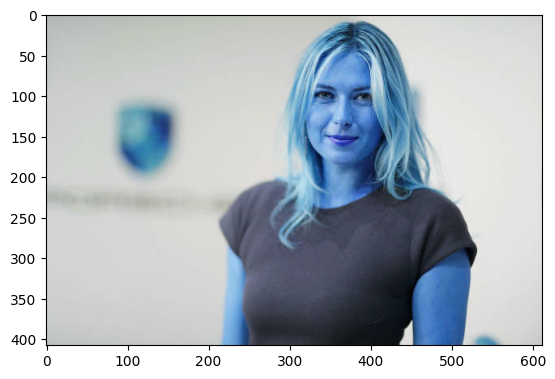

In [36]:
plt.imshow(img)

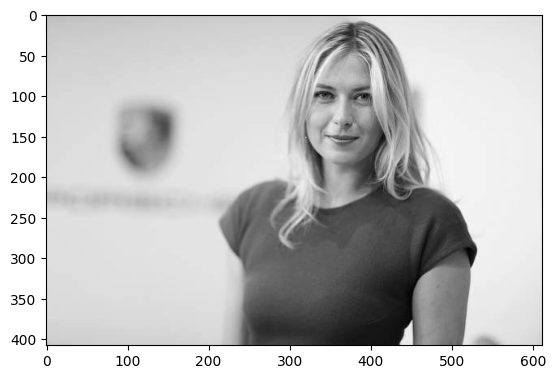

In [37]:
#Converting the image into grayscale image
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap="gray")

In [38]:
print(gray) #2D

[[179 179 179 ... 208 208 208]
 [180 180 180 ... 208 208 208]
 [180 180 180 ... 209 209 209]
 ...
 [193 193 193 ... 201 201 201]
 [192 192 192 ... 201 201 201]
 [192 192 192 ... 201 201 201]]


In [39]:
print(gray.shape)

(408, 612)


## Using Haar Cascade

+ Haar Cascade is a machine learning-based approach used for object detection in images or videos. It was proposed by Paul Viola and Michael Jones in their paper titled "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. Haar Cascades are particularly effective for detecting objects that have well-defined features, such as faces, eyes, cars, and so on.
+ Haar features are simple rectangular patterns that can be used to describe objects. These features are like templates that are applied over the entire image at different scales and locations.(line and edge features)
  

### Detecting the face

In [40]:
face_cascade=cv2.CascadeClassifier(r"D:\Classification_project\model\opencv\haarcascades\haarcascade_frontalface_default.xml")
eye_cascade=cv2.CascadeClassifier(r"D:\Classification_project\model\opencv\haarcascades\haarcascade_eye.xml")

In [41]:
faces=face_cascade.detectMultiScale(gray,scaleFactor=1.1, minNeighbors=5)
#It is possible that there can be multiple faces in the image so faces[0] , faces[1] ,etc. can be used to detect them all

In [42]:
(x,y,w,h)=faces[0]
print(x,y,w,h) #x and y Coordinates and width and height of the face detected

303 53 128 128


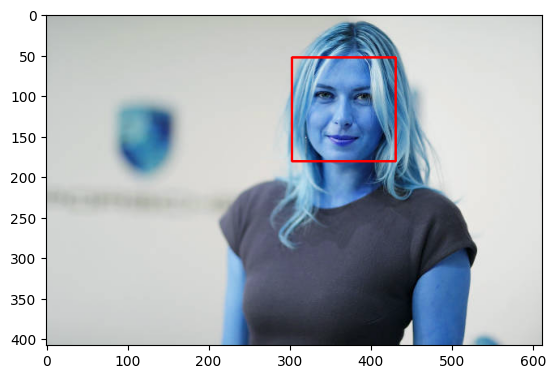

In [43]:
#Drawing recatnge around the detected face
face_img=cv2.rectangle(img,(x,y),(x+h,y+w),(255,0,0),2)
plt.imshow(face_img)

### Detecting the eyes

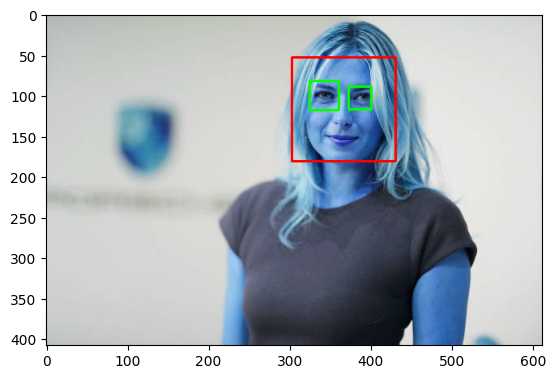

In [12]:
cv2.destroyAllWindows()
for (x, y, w, h) in faces:
    # Draw rectangle around the face
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    # Get the region of interest
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    
    eyes = eye_cascade.detectMultiScale(roi_gray)
    
    # Iterate over detected eyes and draw rectangles
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)

plt.figure()
plt.imshow(face_img,cmap="gray")
plt.show()


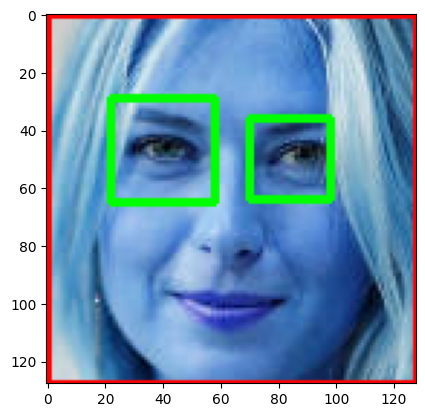

In [13]:
plt.imshow(roi_color,cmap="gray")

In [14]:
def get_cropped_image_if_two_eyes(img_path):
    img=cv2.imread(img_path)
    if img is None:
        print("Failed to load an image")
        return None
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes=eye_cascade.detectMultiScale(roi_gray)
        if len(eyes)>=2:
            return roi_color

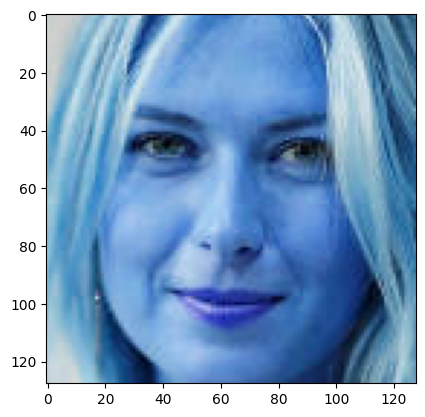

In [15]:
#Testing if the function returns a cropped face from the image
im=get_cropped_image_if_two_eyes(r"D:\Classification_project\model\test_images\sh.jpg")
plt.imshow(im)

In [49]:
#setting the path of the dataset folder and the cleaned dataset folder
path_to_dataset=r"D:\Classification_project\model\image_folder"
path_to_cleaned_dataset=r"D:\Classification_project\model\image_folder\Cleaned_data"

In [50]:
#creating a list of all the separate folders containing the data
img_dirs=[]
for dir in os.scandir(path_to_dataset):
    if dir.is_dir():
        img_dirs.append(dir.path)
img_dirs

['D:\\Classification_project\\model\\image_folder\\Cleaned_data',
 'D:\\Classification_project\\model\\image_folder\\Lionel Messi',
 'D:\\Classification_project\\model\\image_folder\\Maria sharapova',
 'D:\\Classification_project\\model\\image_folder\\mary kom',
 'D:\\Classification_project\\model\\image_folder\\ronaldo',
 'D:\\Classification_project\\model\\image_folder\\virat kohli']

In [51]:
#creating the new folder for cleaned dataset
if os.path.exists(path_to_cleaned_dataset):
    shutil.rmtree(path_to_cleaned_dataset)
os.mkdir(path_to_cleaned_dataset)

In [52]:
#cropping the images and storing in the cleaned dataset 
cleaned_img_dirs=[]
celeb_file_names={}
for img_dir in img_dirs:
    count=1
    celeb_name=img_dir.split("\\")[-1]
    celeb_file_names[celeb_name]=[]
    
    for entry in os.scandir(img_dir):
        roi_color=get_cropped_image_if_two_eyes(entry.path)
        if roi_color is not None:
            cleaned_folder=path_to_cleaned_dataset + "\\"+celeb_name
            if not os.path.exists(cleaned_folder):
                os.mkdir(cleaned_folder)
                cleaned_img_dirs.append(cleaned_folder)
                print("Generating cropped images in folder: ",cleaned_folder)
                
            cleaned_file_name=celeb_name + str(count) + ".jpg"
            cleaned_file_path=cleaned_folder + '\\'  + cleaned_file_name
            cv2.imwrite(cleaned_file_path,roi_color)
            celeb_file_names[celeb_name].append(cleaned_file_path)
            count+=1

Generating cropped images in folder:  D:\Classification_project\model\image_folder\Cleaned_data\Lionel Messi
Failed to load an image
Generating cropped images in folder:  D:\Classification_project\model\image_folder\Cleaned_data\Maria sharapova
Failed to load an image
Failed to load an image
Generating cropped images in folder:  D:\Classification_project\model\image_folder\Cleaned_data\mary kom
Generating cropped images in folder:  D:\Classification_project\model\image_folder\Cleaned_data\ronaldo
Failed to load an image
Failed to load an image
Failed to load an image
Failed to load an image
Failed to load an image
Failed to load an image
Generating cropped images in folder:  D:\Classification_project\model\image_folder\Cleaned_data\virat kohli
Failed to load an image
Failed to load an image
Failed to load an image
Failed to load an image


In [53]:
cleaned_img_dirs

['D:\\Classification_project\\model\\image_folder\\Cleaned_data\\Lionel Messi',
 'D:\\Classification_project\\model\\image_folder\\Cleaned_data\\Maria sharapova',
 'D:\\Classification_project\\model\\image_folder\\Cleaned_data\\mary kom',
 'D:\\Classification_project\\model\\image_folder\\Cleaned_data\\ronaldo',
 'D:\\Classification_project\\model\\image_folder\\Cleaned_data\\virat kohli']

In [54]:
celeb_file_names

{'Cleaned_data': [],
 'Lionel Messi': ['D:\\Classification_project\\model\\image_folder\\Cleaned_data\\Lionel Messi\\Lionel Messi1.jpg',
  'D:\\Classification_project\\model\\image_folder\\Cleaned_data\\Lionel Messi\\Lionel Messi2.jpg',
  'D:\\Classification_project\\model\\image_folder\\Cleaned_data\\Lionel Messi\\Lionel Messi3.jpg',
  'D:\\Classification_project\\model\\image_folder\\Cleaned_data\\Lionel Messi\\Lionel Messi4.jpg',
  'D:\\Classification_project\\model\\image_folder\\Cleaned_data\\Lionel Messi\\Lionel Messi5.jpg',
  'D:\\Classification_project\\model\\image_folder\\Cleaned_data\\Lionel Messi\\Lionel Messi6.jpg',
  'D:\\Classification_project\\model\\image_folder\\Cleaned_data\\Lionel Messi\\Lionel Messi7.jpg',
  'D:\\Classification_project\\model\\image_folder\\Cleaned_data\\Lionel Messi\\Lionel Messi8.jpg',
  'D:\\Classification_project\\model\\image_folder\\Cleaned_data\\Lionel Messi\\Lionel Messi9.jpg',
  'D:\\Classification_project\\model\\image_folder\\Cleaned_dat

In [55]:
#function to do wavelet transformation on images for feature extraction
def w2d(img,mode="haar",level=1):
    imArray=img
    #datatype conversion"
    #convert to grayscale
    imArray=cv2.cvtColor(imArray,cv2.COLOR_BGR2GRAY)
    #convert to float
    imArray=np.float32(imArray)
    imArray/=255
    #computer coefficients
    coeffs=pywt.wavedec2(imArray,mode,level=level)
    
    #process coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0]*=0
    #reconstruction
    imArray_H=pywt.waverec2(coeffs_H,mode)
    imArray_H*=255
    imArray_H=np.uint8(imArray_H)

    return imArray_H

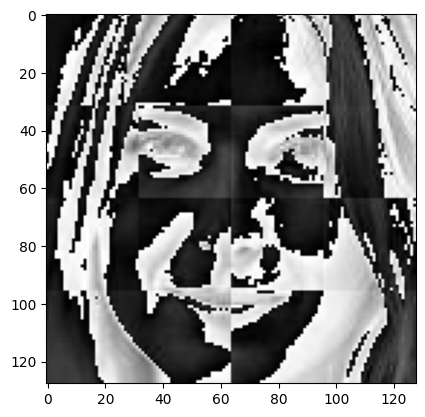

In [56]:
im_har=w2d(im,"db1",5)
plt.imshow(im_har,cmap="gray")

In [60]:
class_dict={}
count=0
for celeb_name in celeb_file_names.keys():
    if celeb_name=="Cleaned_data":
        continue
    class_dict[celeb_name]=count
    count=count+1
class_dict

{'Lionel Messi': 0,
 'Maria sharapova': 1,
 'mary kom': 2,
 'ronaldo': 3,
 'virat kohli': 4}

In [61]:
#dividing testing data and results
x=[] #input:stacked image wavelet transfromed and raw
y=[]
for celeb_name , training_files in celeb_file_names.items():
    for training_image in training_files:
        img=cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img=cv2.resize(img,(32,32))
        img_har=w2d(img,"db1",5)
        scalled_img_har=cv2.resize(img_har,(32,32))
        combined_img=np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        x.append(combined_img)
        y.append(class_dict[celeb_name])


In [62]:
len(x)

109

In [63]:
len(y)

109

In [64]:
len(x[0])

4096

In [65]:
x=np.array(x).reshape(len(x),4096).astype(float)
x.shape

(109, 4096)

#### Training the model

In [68]:
X_train, X_test, y_train, y_test = train_test_split(x, y,random_state=0)

In [69]:
pipe=Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel="rbf",C=10))])

In [70]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=10))])

In [71]:
pipe.score(X_test,y_test)

0.7857142857142857

In [72]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.50      1.00      0.67         3
           2       0.83      1.00      0.91         5
           3       1.00      0.62      0.77         8
           4       0.67      1.00      0.80         4

    accuracy                           0.79        28
   macro avg       0.80      0.85      0.78        28
weighted avg       0.87      0.79      0.79        28



### Hyperparameter tuning

In [77]:
model_params={
    'svm':{
        "model":svm.SVC(gamma="auto",probability=True),
        "params":{
            "svc__C": [1,10,100,1000],
            "svc__kernel":["rbf","linear","poly"]
        }
        
    },
    "random_forest":{
        "model":RandomForestClassifier(),
        "params":{
            "randomforestclassifier__n_estimators":[1,5,10,15] #number of decision trees
        }
    },
    "logistic_regression": {
         "model":LogisticRegression(solver="liblinear",multi_class="auto"),
         "params":{
             "logisticregression__C":[1,5,10]
         } 
    
    }}

In [78]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False) #validation set
    clf.fit(X_train, y_train)
    scores.append({
    'model': algo,
    'best_score': clf.best_score_,
    'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\gurle\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\gurle\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\gurle\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\gurle\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

,model,best_score,best_params
0,svm,0.788971,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.678676,{'randomforestclassifier__n_estimators': 15}
2,logistic_regression,0.814706,{'logisticregression__C': 1}


In [79]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=10, gamma='auto', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=15))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, multi_class='auto',
                                     solver='liblinear'))])}

In [80]:
best_estimators["svm"]

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, gamma='auto', probability=True))])

In [81]:
best_estimators["logistic_regression"].score(X_test,y_test)

0.7142857142857143

In [82]:
best_estimators["svm"].score(X_test,y_test)

0.7857142857142857

In [83]:
best_estimators["random_forest"].score(X_test,y_test)

0.6785714285714286

In [84]:
best_clf=best_estimators["svm"]

Text(95.72222222222221, 0.5, 'Truth')

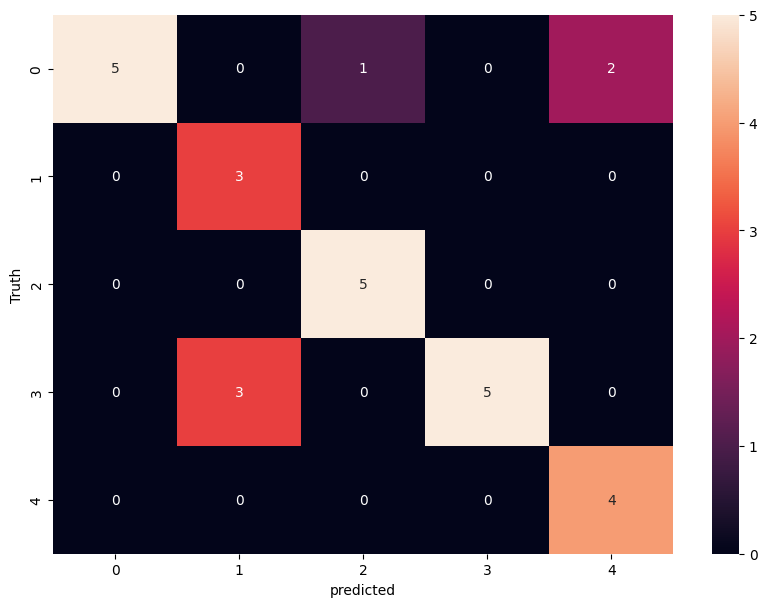

In [87]:
cm=confusion_matrix(y_test,best_clf.predict(X_test))
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel("predicted")
plt.ylabel("Truth")

In [92]:
model_path = os.path.join(R"D:\Classification_project\model", 'saved_model.pkl')
joblib.dump(best_clf,model_path)

['D:\\Classification_project\\model\\saved_model.pkl']

In [94]:
file_path = os.path.join(r"D:\Classification_project\model" ,"class_dictionary.json")

# Save the JSON file to the specified path
with open(file_path, "w") as f:
    f.write(json.dumps(class_dict))